In [1]:
import cv2
import tensorflow as tf
from glob import glob
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image


PATH = "../input/augmented-data/BUSI - Augmented Dataset"

# Segmentation

In [2]:
# # preprocessing
# def process_image(image, HEIGHT=256, WIDTH=256):
#     image = image.decode("utf-8")
#     image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
#     image = cv2.resize(image, (HEIGHT, WIDTH))
#     image = image / 255.0

#     image = image.astype(np.float32)
#     image = np.expand_dims(image, axis=-1)
#     return image


# def process_mask(mask):
#     mask = mask.astype(np.float32)
#     mask = mask / 255
#     mask = np.round(mask) # Rounds between 0 and 1 each pixels
#     mask = np.expand_dims(mask, axis=-1)  # need shape to be (256,256,1)
#     return mask

# def preprocess(x, y):
#     def f(x, y):
#         image = process_image(x)
#         mask = process_mask(y)
#         return image, mask

#     image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
#     image.set_shape([256, 256, 1])
#     mask.set_shape([256, 256, 1])
#     return image, mask

In [3]:
# # combine real masks where there are more masks for the same image
# def group_masks(masks):
#     new_masks = []
#     index = 0
#     for i in range(len(masks)):
#         m = re.search(r"mask_[0-9]", masks[i]) # we are looking for masks that correspond to the same inputs
#         if m:
#             new_masks[i - (index + 1)] += cv2.resize(
#                 cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE), (256, 256)
#             )
#             index += 1
#         else:
#             new_masks.append(
#                 cv2.resize(
#                     cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE), (256, 256)
#                 )  # resize needed because all the images need to have the same size
#             )

#     return new_masks

In [4]:
# benign_images = sorted(
#         glob(os.path.join(PATH,"benign/*).png")),
#         key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)],
#     )
# benign_masks = group_masks(sorted(
#         glob(os.path.join(PATH, "benign/*mask*")),
#         key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)],
#     ))
# malignant_images = sorted(
#         glob(os.path.join(PATH,"malignant/*).png")),
#         key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)],
#     )
# malignant_masks = group_masks(sorted(
#         glob(os.path.join(PATH, "malignant/*mask*")),
#         key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)],
#     ))
# normal_images = sorted(
#         glob(os.path.join(PATH,"normal/*).png")),
#         key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)],
#     )
# normal_masks = group_masks(sorted(
#         glob(os.path.join(PATH, "normal/*mask*")),
#         key=lambda x: [int(c) if c.isdigit() else c for c in re.split(r"(\d+)", x)],
#     ))

In [5]:
# # Version 1: we just train on benign and malignant masks
# all_images = benign_images + malignant_images
# all_masks = benign_masks + malignant_masks
# X_train, X_test = train_test_split(
#         all_images,
#         test_size=0.2,
#         random_state=1,
#         shuffle=True
#     )
# y_train, y_test = train_test_split(
#     all_masks,
#     test_size=0.2,
#     random_state=1,
#     shuffle=True
# )
# batch_size = 16

In [6]:
# # According to the tensorflow documentation, images converted to tf.data format are more suitable
# # for Keras models. So, we will convert our data in tensorflow dataset format
# train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# train_ds = train_ds.map(preprocess)
# train_ds = train_ds.batch(batch_size)
# test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# test_ds = test_ds.map(preprocess)
# test_ds = test_ds.batch(batch_size)

In [7]:
# # The unet algorithm is from HUGO GABRIELIDIS and is proven to give >90% accuracy on breast ultrasound images
# def block_conv_down(x, dims):
#     x = tf.keras.layers.Conv2D(
#         dims,
#         kernel_size=(3, 3),
#         padding="same", # it will pad evenly on the left and on the right
#         kernel_initializer="he_normal", # It draws samples from a truncated normal distribution centered 
#         # on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor
#         # for the weights of the layer
#     )(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation("relu")(x)
#     x = tf.keras.layers.Conv2D(
#         dims,
#         kernel_size=(3, 3),
#         padding="same",
#         kernel_initializer="he_normal",
#     )(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation("relu")(x)
#     p = tf.keras.layers.MaxPool2D((2, 2))(x)
#     p = tf.keras.layers.Dropout(0.2)(p)
#     return x, p

# def bottleneck(x, dims):
#     """
#     This is the same function but without the maxpooling and dropout.
#     """
#     x = tf.keras.layers.Conv2D(
#         dims,
#         (3, 3),
#         padding="same",
#         kernel_initializer="he_normal",
#     )(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation("relu")(x)

#     x = tf.keras.layers.Conv2D(
#         dims,
#         (3, 3),
#         padding="same",
#         kernel_initializer="he_normal",
#     )(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation("relu")(x)
#     return x

# def block_conv_up(x, p, dims):
#     p = tf.keras.layers.UpSampling2D(2)(p) # The Upsampling creates a layer with no weights it doubles 
#     # the dimensions of input and so that it can be used in the generation of the model to be followed 
#     # by a traditional convolutional layer. 
#     u = tf.keras.layers.Concatenate(axis=-1)([p, x]) # It takes as input a list of tensors, all of the 
#     # same shape except for the concatenation axis, and returns a single tensor that is the concatenation 
#     # of all inputs.

#     u = tf.keras.layers.Conv2D(
#         dims,
#         (3, 3),
#         padding="same",
#         kernel_initializer="he_normal",
#     )(u)
#     u = tf.keras.layers.BatchNormalization()(u) # Layer that normalizes its inputs.
#     u = tf.keras.layers.Activation("relu")(u)
#     u = tf.keras.layers.Dropout(0.1)(u)

#     u = tf.keras.layers.Conv2D(
#         dims,
#         (3, 3),
#         padding="same",
#         kernel_initializer="he_normal",
#     )(u)
#     u = tf.keras.layers.BatchNormalization()(u)
#     u = tf.keras.layers.Activation("relu")(u)
#     u = tf.keras.layers.Dropout(0.1)(u)
#     return u

# def UNET(input_shape):
#     input = tf.keras.layers.Input(shape=input_shape)
    
#     # first the image is "reduced" by maxpooling and is activated using relu
#     x1, p1 = block_conv_down(input, 64)
#     # print(f" x1 shape : {x1.shape}")
#     x2, p2 = block_conv_down(p1, 128)
#     # print(f" x2 shape : {x2.shape}")
#     x3, p3 = block_conv_down(p2, 256)
#     # print(f" x3 shape : {x3.shape}")
#     x4, p4 = block_conv_down(p3, 512)
#     # print(f" x4 shape : {x4.shape}")

#     # next another activation without maxpool and then the image is redoubled
#     p5 = bottleneck(p4, 1024)
#     # print(f" p5 shape : {p5.shape}")
#     p6 = block_conv_up(x4, p5, 512)
#     # print(f" p6 shape : {p6.shape}")
#     p7 = block_conv_up(x3, p6, 256)
#     # print(f" p7 shape : {p7.shape}")
#     p8 = block_conv_up(x2, p7, 128)
#     # print(f" p8 shape : {p8.shape}")
#     p9 = block_conv_up(x1, p8, 64)
#     # print(f" p9 shape : {p9.shape}")

#     output = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid")(p9)
#     # output = tf.keras.layers.Conv2D(2,(1,1), activation = "softmax")
#     model = tf.keras.Model(inputs=input, outputs=output)

#     return model

In [8]:
# # Train the model
# model = UNET((256, 256, 1))
        
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3),
#     loss="binary_crossentropy",
#     metrics=["accuracy"],
# )
# model.fit(
#         train_ds,
#         validation_data=test_ds,
#         epochs=50,
#         steps_per_epoch=len(train_ds),
#         )

In [9]:
# history=model.history
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [10]:
# results = model.evaluate(test_ds, batch_size=16)
# print("test loss, test acc:", results)

In [11]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()

# with open("/kaggle/working/masks.tflite", 'wb') as f:
#   f.write(tflite_model)

In [12]:
# all_ds = train_ds.concatenate(test_ds)
# #preds = model.predict(all_ds, batch_size=16)
# #print(len(preds))
# original_images = list(all_ds.map(lambda x, y: y*255))
# images_to_mask = list(all_ds.map(lambda x, y: x*255))
# for i in range(10):
#     pred = model.predict(images_to_mask[i])
#     im_predicted = Image.fromarray(np.squeeze((pred * 255).astype(np.uint8)[0], axis=2))
#     plt.imshow(im_predicted)
#     plt.show()
#     im_true = Image.fromarray(np.squeeze(np.array(original_images[i]).astype(np.uint8)[0], axis=2))
#     plt.imshow(im_true)
#     plt.show()
# # for i in range(10):
# #     im_predicted = Image.fromarray(np.squeeze((preds[i] * 255).astype(np.uint8), axis=2))
# #     plt.imshow(im_predicted)
# #     plt.show()
# #     im_true = Image.fromarray(np.squeeze(np.array(original_images[i]).astype(np.uint8)[0], axis=2))
# #     plt.imshow(im_true)
# #     plt.show()

# Classification

In [13]:
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.layers import Input
from keras.utils.vis_utils import plot_model
import os, shutil
# PATH = "../input/augmented-busi/BUSI - Augmented Dataset"

In [14]:
os.mkdir('/kaggle/working/masks')
os.mkdir('/kaggle/working/masks/benign')
os.mkdir('/kaggle/working/masks/malignant')
os.mkdir('/kaggle/working/masks/normal')

In [15]:
# move only masks to another folder
directory = os.path.join(PATH,"benign/")
for filename in os.listdir(directory):
    #print(filename)
    if "mask" in filename: 
         #print(filename)
         shutil.copy2(os.path.join(PATH,f"benign/{filename}"), f"/kaggle/working/masks/benign/{filename}")

In [16]:
directory = os.path.join(PATH,"malignant/")
for filename in os.listdir(directory):
    #print(filename)
    if "mask" in filename: 
         #print(filename)
         shutil.copy2(os.path.join(PATH,f"malignant/{filename}"), f"/kaggle/working/masks/malignant/{filename}")

In [17]:
directory = os.path.join(PATH,"normal/")
for filename in os.listdir(directory):
    #print(filename)
    if "mask" in filename: 
         #print(filename)
         shutil.copy2(os.path.join(PATH,f"normal/{filename}"), f"/kaggle/working/masks/normal/{filename}")

2022-12-18 10:15:50.932342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 10:15:51.045040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 10:15:51.045811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 10:15:51.048078: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 2256 images belonging to 3 classes.
Found 752 images belonging to 3 classes.


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-18 10:15:54.206673: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/32


2022-12-18 10:15:55.859497: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


18/18 [==============================] - 12s 232ms/step - loss: 1.7539 - acc: 0.6128 - val_loss: 0.9016 - val_acc: 0.7500
Epoch 2/32
18/18 [==============================] - 4s 220ms/step - loss: 0.7730 - acc: 0.8368 - val_loss: 0.6821 - val_acc: 0.8854
Epoch 3/32
18/18 [==============================] - 4s 230ms/step - loss: 0.4558 - acc: 0.8559 - val_loss: 0.4136 - val_acc: 0.8333
Epoch 4/32
18/18 [==============================] - 4s 224ms/step - loss: 0.3119 - acc: 0.8821 - val_loss: 0.4318 - val_acc: 0.8542
Epoch 5/32
18/18 [==============================] - 4s 230ms/step - loss: 0.2609 - acc: 0.9179 - val_loss: 0.5020 - val_acc: 0.8229
Epoch 6/32
18/18 [==============================] - 4s 217ms/step - loss: 0.2321 - acc: 0.9201 - val_loss: 0.5571 - val_acc: 0.8542
Epoch 7/32
18/18 [==============================] - 4s 213ms/step - loss: 0.2381 - acc: 0.9196 - val_loss: 0.6208 - val_acc: 0.8125
Epoch 8/32
18/18 [==============================] - 4s 230ms/step - loss: 0.1675 - acc

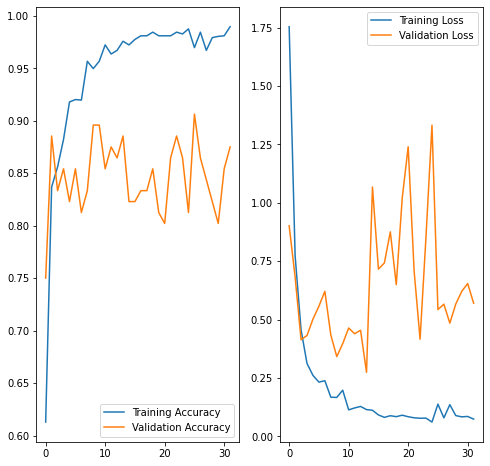

In [18]:
#def train_validate_v1(batch_size, epochs, steps_train, steps_val):
batch_size = 32
epochs = 32
steps_train = 18
steps_val = 3
# Defines & compiles the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(400, 400, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
keras.layers.Dropout(rate=0.15), #adding dropout regularization throughout the model to deal with overfitting
# The second convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
keras.layers.Dropout(rate=0.1),
# The third convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
keras.layers.Dropout(rate=0.10),
# Flatten the results to feed into a DNN
tf.keras.layers.Flatten(),
# 512 neuron hidden layer
tf.keras.layers.Dense(512, activation='relu'),

# 3 output neuron for the 3 classes of Animal Images
tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
          optimizer="adam",
          metrics=['acc'])

# Creates an instance of an ImageDataGenerator called train_datagen, and a train_generator, train_datagen.flow_from_directory
#splits data into training and testing(validation) sets
train_datagen =ImageDataGenerator(rescale=1./255, validation_split=0.25)

#training data
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/masks/',  # Source directory
    target_size=(400, 400),  # Resizes images
    batch_size=batch_size,
    class_mode='categorical',subset = 'training')

epochs = epochs
#Testing data
validation_generator = train_datagen.flow_from_directory(
'/kaggle/working/masks/',
target_size=(400, 400),
batch_size=batch_size,
class_mode='categorical',
subset='validation') # set as validation data

#Model fitting for a number of epochs
history = model.fit_generator(
  train_generator,
  steps_per_epoch=steps_train,
  epochs=epochs,
  validation_data = validation_generator,
  validation_steps = steps_val,
  verbose=1)

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

#This code is used to plot the training and validation accuracy
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

# returns accuracy of training
# print("Training Accuracy:"), print(history.history['acc'][-1])
# print("Testing Accuracy:"), print (history.history['val_acc'][-1])
# #     converter = tf.lite.TFLiteConverter.from_keras_model(model)
# #     converter.optimizations = [tf.lite.Optimize.DEFAULT]
# #     tflite_model = converter.convert
# model.save("model_augmentat_clasificare.h5")
# history=model.history
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [19]:
# train_validate_v1(32, 32, 18, 3)